In [ ]:
import h5py
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
import math
import numpy.linalg as la
from tqdm import tqdm
from tabulate import tabulate

# Загрузка данных
with h5py.File('../data/raw_data/METR-LA/METR-LA.h5', 'r') as file:
    axis0 = file['df']['axis0'][:]              # Идентификаторы датчиков
    axis1 = file['df']['axis1'][:]              # Метки времени
    timestamps = pd.to_datetime(axis1)          # Преобразование меток времени в формат datetime
    df_data = file['df']['block0_values'][:]    # Данные замеров скорости

axis0 = [x.decode('utf-8') for x in axis0]
metr_la = pd.DataFrame(df_data, index=timestamps, columns=axis0)
metr_la = metr_la.iloc[:2016]

# Загрузка матрицы смежности
with open('../data/raw_data/METR-LA/adj_METR-LA.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

node_ids = [x.decode('utf-8') for x in data[0]]  # Получаем список id узлов из data[0]
adj_matrix = data[2]  # Получаем матрицу смежности из data[2]
metr_la_adj = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids)  # Создание DataFrame

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
import h5py
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
import math
import numpy.linalg as la
from tqdm import tqdm
from tabulate import tabulate

# Загрузка данных
with h5py.File('../data/raw_data/METR-LA/METR-LA.h5', 'r') as file:
    axis0 = file['df']['axis0'][:]              # Идентификаторы датчиков
    axis1 = file['df']['axis1'][:]              # Метки времени
    timestamps = pd.to_datetime(axis1)          # Преобразование меток времени в формат datetime
    df_data = file['df']['block0_values'][:]    # Данные замеров скорости

axis0 = [x.decode('utf-8') for x in axis0]
metr_la = pd.DataFrame(df_data, index=timestamps, columns=axis0)
metr_la = metr_la.iloc[:2016, :2]

# Загрузка матрицы смежности
with open('../data/raw_data/METR-LA/adj_METR-LA.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

node_ids = [x.decode('utf-8') for x in data[0]]  # Получаем список id узлов из data[0]
adj_matrix = data[2]  # Получаем матрицу смежности из data[2]
metr_la_adj = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids)  # Создание DataFrame

from utils import *

# Словарь функций для создания признаков
feature_functions = {
    'mean': mean_feature,
    'median': median_feature,
    'std': std_feature,
    'min': min_feature,
    'max': max_feature,
    # 'kurtosis': kurtosis_feature,
    # 'skew': skew_feature,
    # 'quantile': quantile_feature,
    # 'weekday': weekday_feature,
    # 'hour': hour_feature,
    # 'peak_hours': peak_hours_feature,
    # 'is_holiday': is_holiday_feature,
    # 'season': season_feature,
    'rolling_mean': rolling_mean_feature,
    'rolling_std': rolling_std_feature,
    'rolling_min': rolling_min_feature,
    'rolling_max': rolling_max_feature,
    # 'fft': fft_feature,
    # 'dwt': dwt_feature,
    'diff': diff_feature,
    # 'autocorr': autocorr_feature,
}

graph_feature_functions = {
    'degree': degree_feature,
    'weighted_degree': weighted_degree_feature,
    'degree_centrality': degree_centrality_feature,
    'closeness_centrality': closeness_centrality_feature,
    'betweenness_centrality': betweenness_centrality_feature,
    'eigenvector_centrality': eigenvector_centrality_feature,
    'edge_weight': edge_weight_feature,
    # 'shortest_path_length': shortest_path_length_feature,
    'graph_density': graph_density_feature,
    # 'graph_diameter': graph_diameter_feature,
    'clustering_coefficient': clustering_coefficient_feature,
}


import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Нормализация данных
def normalize_data(trainX, testX):
    scaler = MinMaxScaler()
    trainX_shape = trainX.shape
    testX_shape = testX.shape
    trainX = scaler.fit_transform(trainX.reshape(-1, trainX_shape[-1])).reshape(trainX_shape)
    testX = scaler.transform(testX.reshape(-1, testX_shape[-1])).reshape(testX_shape)
    return trainX, testX, scaler

# Функция для добавления дополнительных фичей
def add_features(data, feature_list, index=None, adj_matrix=None, **kwargs):
    """
    Добавляет фичи в данные, поддерживая канал измерений и графовые признаки.

    Args:
        data (np.ndarray): Исходные данные, shape: [time, nodes, channels] или [time, nodes].
        feature_list (list): Список названий признаков для добавления.
        index (pd.DatetimeIndex): Индекс времени для временных признаков.
        adj_matrix (np.ndarray): Матрица смежности для графовых признаков.
        **kwargs: Дополнительные аргументы для функций.

    Returns:
        np.ndarray: Обновленные данные с дополнительными фичами, shape: [time, nodes, channels+N].
    """
    # Если данных нет размерности каналов, добавляем её
    if len(data.shape) == 2:  # [time, nodes]
        data = data[..., np.newaxis]  # Преобразуем в [time, nodes, 1]

    # Преобразуем данные в DataFrame для удобства добавления фичей
    time, nodes, channels = data.shape
    df = pd.DataFrame(data.reshape(time, -1))

    # Добавляем фичи
    new_features = []

    # Генерация временных или статистических признаков
    for feature_name in feature_list:
        if feature_name in feature_functions:
            func = feature_functions[feature_name]
            if feature_name in ['weekday', 'hour', 'peak_hours', 'is_holiday', 'season']:
                feature = func(df.values, index)
            else:
                feature = func(df.values, **kwargs)

            # Если признак имеет форму (nodes,), растягиваем его по временной оси
            if feature.ndim == 1:
                feature = np.tile(feature, (time, 1))  # Преобразуем в (time, nodes)
            elif feature.ndim == 2 and feature.shape[0] != time:
                raise ValueError(f"Признак '{feature_name}' имеет несовместимую форму: {feature.shape}")

            new_features.append(feature[..., np.newaxis])  # Добавляем размерность каналов
            print(f'{feature_name}: {feature.shape = }')
        else:
            raise ValueError(f"Функция для признака '{feature_name}' не найдена.")

    # Генерация графовых признаков, если задана матрица смежности
    if adj_matrix is not None:

        for name, func in graph_feature_functions.items():
            graph_feature = func(adj_matrix.values)  # Признак в виде словаря {node_id: value}
            graph_feature = np.array([graph_feature[node] for node in range(nodes)])  # Преобразуем в массив [nodes]
            graph_feature = np.tile(graph_feature, (time, 1))  # Растягиваем по временной оси до [time, nodes]
            new_features.append(graph_feature[..., np.newaxis])  # Добавляем размерность каналов
            print(f'Graph feature ({name}): {graph_feature.shape = }')

    # Объединяем оригинальные данные и новые фичи
    new_features = np.concatenate(new_features, axis=-1)  # [time, nodes, N]
    data = np.concatenate([data, new_features], axis=-1)  # [time, nodes, channels + N]
    return data

# Предобработка данных
def preprocess_data_multichannel(data, time_len, rate, seq_len, pre_len):
    """
    Преобразует данные в формат [batch, seq_len, nodes, channels].

    Args:
        data (np.ndarray): Исходные данные, shape: [time, nodes, channels].
        time_len (int): Общее количество временных точек.
        rate (float): Доля обучающей выборки.
        seq_len (int): Длина входной последовательности.
        pre_len (int): Длина предсказания.

    Returns:
        tuple: (trainX, trainY, testX, testY)
    """
    train_size = int(time_len * rate)
    train_data = data[:train_size]
    test_data = data[train_size:time_len]

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0: seq_len])  # Shape: [seq_len, nodes, channels]
        trainY.append(a[seq_len: seq_len + pre_len])  # Shape: [pre_len, nodes, channels]
    for i in range(len(test_data) - seq_len - pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0: seq_len])
        testY.append(b[seq_len: seq_len + pre_len])
    
    return np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

# Пример использования
time_len = len(metr_la)
rate = 0.8
seq_len = 12
pre_len = 3

# Индекс времени
index = pd.to_datetime(metr_la.index)

# Добавление mean и std
metr_la_array = metr_la.values  # Исходные данные [time, nodes]
metr_la_array = metr_la.values  # Исходные данные [time, nodes]
metr_la_extended = add_features(
    metr_la_array,
    feature_list=list(feature_functions.keys()),    # Список признаков
    index=index,                                    # Индекс времени для временных признаков
    adj_matrix=metr_la_adj
)

# Преобразование в массив [time, nodes, channels]
trainX, trainY, testX, testY = preprocess_data_multichannel(metr_la_extended, time_len, rate, seq_len, pre_len)

# Нормализация данных
trainX_norm, testX_norm, scaler_X = normalize_data(trainX, testX)
trainY_norm, testY_norm, scaler_Y = normalize_data(trainY, testY)

# Преобразование в тензоры PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainX_norm = torch.tensor(trainX_norm, dtype=torch.float32).to(device)
trainY_norm = torch.tensor(trainY_norm, dtype=torch.float32).to(device)
testX_norm = torch.tensor(testX_norm, dtype=torch.float32).to(device)
testY_norm = torch.tensor(testY_norm, dtype=torch.float32).to(device)


# Вывод размерности данных
print(f"TrainX shape: {trainX_norm.shape}")  # [batch, seq_len, nodes, channels]
print(f"TrainY shape: {trainY_norm.shape}")  # [batch, pre_len, nodes, channels]
print(f"TestX shape: {testX_norm.shape}")    # [batch, seq_len, nodes, channels]
print(f"TestY shape: {testY_norm.shape}")    # [batch, pre_len, nodes, channels]


mean: feature.shape = (2016, 2)
median: feature.shape = (2016, 2)
std: feature.shape = (2016, 2)
min: feature.shape = (2016, 2)
max: feature.shape = (2016, 2)
rolling_mean: feature.shape = (2016, 2)
rolling_std: feature.shape = (2016, 2)
rolling_min: feature.shape = (2016, 2)
rolling_max: feature.shape = (2016, 2)
diff: feature.shape = (2016, 2)
Graph feature (degree): graph_feature.shape = (2016, 2)
Graph feature (weighted_degree): graph_feature.shape = (2016, 2)
Graph feature (degree_centrality): graph_feature.shape = (2016, 2)
Graph feature (closeness_centrality): graph_feature.shape = (2016, 2)
Graph feature (betweenness_centrality): graph_feature.shape = (2016, 2)
Graph feature (eigenvector_centrality): graph_feature.shape = (2016, 2)
Graph feature (edge_weight): graph_feature.shape = (2016, 2)
Graph feature (graph_density): graph_feature.shape = (2016, 2)
Graph feature (clustering_coefficient): graph_feature.shape = (2016, 2)
TrainX shape: torch.Size([1597, 12, 2, 20])
TrainY sha

In [22]:
metr_la_extended.shape

(2016, 2, 20)

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, pre_len=3):
        super(LSTMModel, self).__init__()
        self.pre_len = pre_len
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch, seq_len, nodes, channels]
        batch, seq_len, nodes, channels = x.size()
        x = x.view(batch * nodes, seq_len, channels)  # Merge batch and nodes dimensions for LSTM
        
        h_lstm, _ = self.lstm(x)  # h_lstm shape: [batch * nodes, seq_len, hidden_size]
        h_lstm = h_lstm[:, -self.pre_len:, :]  # Take last `pre_len` steps
        
        out = self.fc(h_lstm)  # shape: [batch * nodes, pre_len, output_size]
        out = out.view(batch, nodes, self.pre_len, -1).permute(0, 2, 1, 3)  # [batch, pre_len, nodes, output_size]
        return out  # Final shape: [batch, pre_len, nodes, 1]


In [26]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, pre_len=3):
        super(GRUModel, self).__init__()
        self.pre_len = pre_len
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch, seq_len, nodes, channels]
        batch, seq_len, nodes, channels = x.size()
        x = x.view(batch * nodes, seq_len, channels)  # Merge batch and nodes dimensions for GRU
        
        h_gru, _ = self.gru(x)  # h_gru shape: [batch * nodes, seq_len, hidden_size]
        h_gru = h_gru[:, -self.pre_len:, :]  # Take last `pre_len` steps
        
        out = self.fc(h_gru)  # shape: [batch * nodes, pre_len, output_size]
        out = out.view(batch, nodes, self.pre_len, -1).permute(0, 2, 1, 3)  # [batch, pre_len, nodes, output_size]
        return out  # Final shape: [batch, pre_len, nodes, 1]


In [27]:
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout=0.2, pre_len=3):
        super(TCNModel, self).__init__()
        self.pre_len = pre_len
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size, padding=(kernel_size - 1)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, padding=(kernel_size - 1)),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(num_channels, output_size)

    def forward(self, x):
        # x shape: [batch, seq_len, nodes, channels]
        batch, seq_len, nodes, channels = x.size()
        x = x.permute(0, 2, 3, 1)  # (batch, seq_len, nodes, channels) -> (batch, nodes, channels, seq_len)
        x = x.reshape(batch * nodes, channels, seq_len)  # Merge batch and nodes dimensions

        out = self.tcn(x)  # shape: [batch * nodes, num_channels, seq_len + kernel_size - 1]
        out = out[:, :, -self.pre_len:]  # Use last `pre_len` time steps, shape: [batch * nodes, num_channels, pre_len]
        
        out = out.permute(0, 2, 1)  # shape: [batch * nodes, pre_len, num_channels]
        out = self.fc(out)  # shape: [batch * nodes, pre_len, output_size]
        out = out.view(batch, nodes, self.pre_len, -1).permute(0, 2, 1, 3)  # [batch, pre_len, nodes, output_size]
        return out  # Final shape: [batch, pre_len, nodes, 1]


In [24]:
def train_model(model, trainX, trainY, testX, testY, scaler_Y, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(trainX)  # outputs shape: [batch, pre_len, output_size]
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Оценка модели
    model.eval()
    with torch.no_grad():
        predictions_norm = model(testX).cpu().numpy()  # predictions shape: [batch, pre_len, output_size]

    # Восстановление данных
    predictions = scaler_Y.inverse_transform(predictions_norm.reshape(-1, predictions_norm.shape[-1]))
    predictions = predictions.reshape(predictions_norm.shape)  # Восстановление исходной формы
    actuals = scaler_Y.inverse_transform(testY.cpu().numpy().reshape(-1, testY.shape[-1]))
    actuals = actuals.reshape(testY.shape)  # Восстановление исходной формы

    # Метрики
    rmse = np.sqrt(mean_squared_error(actuals.reshape(-1), predictions.reshape(-1)))
    mae = mean_absolute_error(actuals.reshape(-1), predictions.reshape(-1))
    r2 = r2_score(actuals.reshape(-1), predictions.reshape(-1))
    var = np.var(actuals - predictions)
    return rmse, mae, r2, var

In [28]:
from sklearn.model_selection import ParameterGrid
from tabulate import tabulate

# Определение сеток параметров для всех моделей
param_grids = {
    "LSTM": {
        "hidden_size": [64],
        "num_layers": [4],
        "lr": [ 0.002],
        "epochs": [300]
    },
    "GRU": {
        "hidden_size": [64],
        "num_layers": [4],
        "lr": [0.002],
        "epochs": [300]
    },
    "TCN": {
        "num_channels": [64],
        "kernel_size": [3],
        "lr": [0.002],
        "epochs": [300]
    }
}

# Функция для Grid Search
def grid_search(model_class, param_grid, trainX, trainY, testX, testY, scaler_Y, model_name):
    best_rmse = float("inf")
    best_params = None
    results = []

    # Перебор всех комбинаций параметров
    for params in ParameterGrid(param_grid):
        print(f"Testing {model_name} with params: {params}")

        # Создание модели
        if model_name == "TCN":
            model = model_class(
                input_size=trainX.shape[3],  # Размерность входных фичей (channels)
                output_size=trainY.shape[3],  # Размерность выходных фичей (channels)
                num_channels=params["num_channels"],
                kernel_size=params["kernel_size"],
                pre_len=trainY.shape[1]
            )
        else:  # Для LSTM и GRU
            model = model_class(
                input_size=trainX.shape[3],
                hidden_size=params["hidden_size"],
                output_size=trainY.shape[3],
                num_layers=params["num_layers"],
                pre_len=trainY.shape[1]
            )

        # Обучение модели
        rmse, mae, r2, var = train_model(
            model, trainX, trainY, testX, testY, scaler_Y,
            epochs=params["epochs"], lr=params["lr"]
        )

        # Сохранение результатов
        results.append({
            "model": model_name,
            "params": params,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "var": var
        })

        # Обновление лучших параметров
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    return best_params, best_rmse, results

# Функция для выполнения Grid Search для всех моделей
def run_grid_search(models, param_grids, trainX, trainY, testX, testY, scaler_Y):
    all_results = []

    for model_name, model_class in models.items():
        print(f"Running Grid Search for {model_name}...")
        best_params, best_rmse, results = grid_search(
            model_class, param_grids[model_name], trainX, trainY, testX, testY, scaler_Y, model_name
        )
        print(f"Best params for {model_name}: {best_params}")
        print(f"Best RMSE for {model_name}: {best_rmse}")
        all_results.extend(results)

    # Вывод всех результатов в табличной форме
    print("All results:")
    print(tabulate(all_results, headers="keys"))

# Определение моделей
models = {
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "TCN": TCNModel
}

# Запуск Grid Search
run_grid_search(models, param_grids, trainX_norm, trainY_norm, testX_norm, testY_norm, scaler_Y)

Running Grid Search for LSTM...
Testing LSTM with params: {'epochs': 300, 'hidden_size': 64, 'lr': 0.002, 'num_layers': 4}
Epoch [100/300], Loss: 0.1446
Epoch [200/300], Loss: 0.1446
Epoch [300/300], Loss: 0.1446
Best params for LSTM: {'epochs': 300, 'hidden_size': 64, 'lr': 0.002, 'num_layers': 4}
Best RMSE for LSTM: 8.917939186096191
Running Grid Search for GRU...
Testing GRU with params: {'epochs': 300, 'hidden_size': 64, 'lr': 0.002, 'num_layers': 4}
Epoch [100/300], Loss: 0.1437
Epoch [200/300], Loss: 0.1424
Epoch [300/300], Loss: 0.1424
Best params for GRU: {'epochs': 300, 'hidden_size': 64, 'lr': 0.002, 'num_layers': 4}
Best RMSE for GRU: 7.483782768249512
Running Grid Search for TCN...
Testing TCN with params: {'epochs': 300, 'kernel_size': 3, 'lr': 0.002, 'num_channels': 64}
Epoch [100/300], Loss: 0.0150
Epoch [200/300], Loss: 0.0107
Epoch [300/300], Loss: 0.0085
Best params for TCN: {'epochs': 300, 'kernel_size': 3, 'lr': 0.002, 'num_channels': 64}
Best RMSE for TCN: 5.862028

rolling_mean: feature.shape = (2016, 2)
rolling_std: feature.shape = (2016, 2)
rolling_min: feature.shape = (2016, 2)
rolling_max: feature.shape = (2016, 2)
diff: feature.shape = (2016, 2)
TrainX shape: torch.Size([1597, 12, 2, 6])
TrainY shape: torch.Size([1597, 3, 2, 6])
TestX shape: torch.Size([389, 12, 2, 6])
TestY shape: torch.Size([389, 3, 2, 6])


In [7]:
feature_functions = {
    'mean': mean_feature,
    'median': median_feature,
    'std': std_feature,
    'min': min_feature,
    'max': max_feature,
    'kurtosis': kurtosis_feature,
    'skew': skew_feature,
    'quantile': quantile_feature,
    'weekday': weekday_feature,
    'hour': hour_feature,
    'peak_hours': peak_hours_feature,
    # 'is_holiday': is_holiday_feature,
    'season': season_feature,
    'rolling_mean': rolling_mean_feature,
    'rolling_std': rolling_std_feature,
    'rolling_min': rolling_min_feature,
    'rolling_max': rolling_max_feature,
    # 'fft': fft_feature,
    # 'dwt': dwt_feature,
    'diff': diff_feature,
    'autocorr': autocorr_feature,
}

<Axes: >

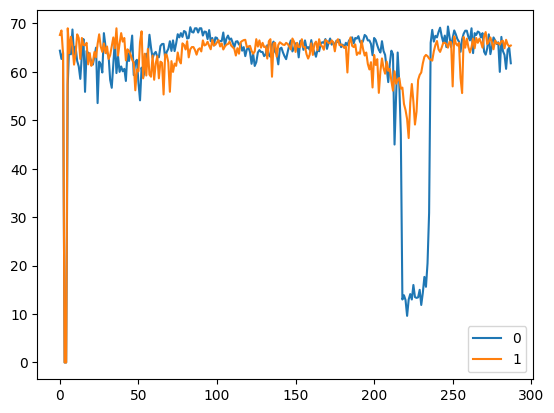

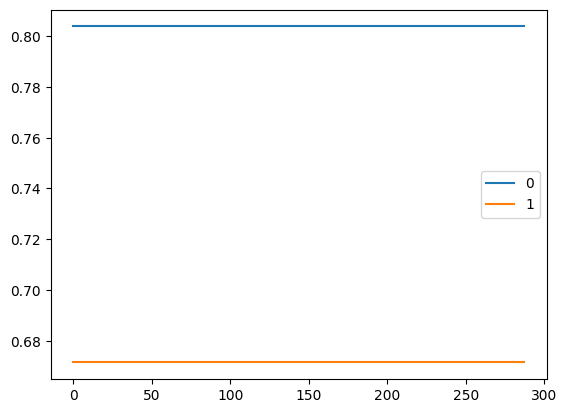

In [25]:
pd.DataFrame(metr_la_extended[:288, :, 0]).plot()
pd.DataFrame(metr_la_extended[:288, :, 18]).plot()

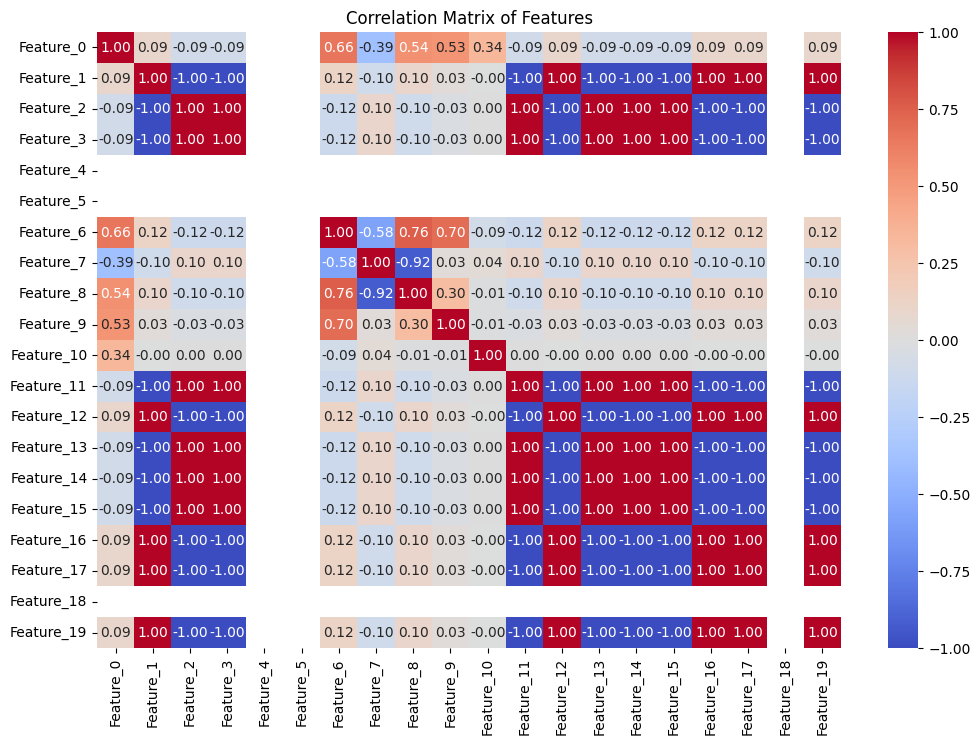

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Преобразование данных в двумерный формат
num_timesteps, num_nodes, num_features = metr_la_extended.shape
data_2d = metr_la_extended.reshape(-1, num_features)  # Форма: (2016 * 2, 19)

# 2. Создание DataFrame для удобства
df = pd.DataFrame(data_2d, columns=[f'Feature_{i}' for i in range(num_features)])

# 3. Вычисление матрицы корреляции
correlation_matrix = df.corr()

# 4. Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()